In [87]:
import os, sys, time, pickle, glob
from pathlib import Path

# numpy to SITK conversion
import torch
import numpy     as np
import SimpleITK as sitk

def sitk2np(obj): return np.swapaxes(sitk.GetArrayFromImage(obj), 0, 2)
def np2sitk(arr): return sitk.GetImageFromArray(np.swapaxes(arr, 0, 2))

def torch2sitk(t): return sitk.GetImageFromArray(torch.transpose(t, 0, 2))
def sitk2torch(o): return torch.transpose(torch.tensor(sitk.GetArrayFromImage(o)), 0, 2)


# meshio for 3DSlicer segm obj
import meshio


# segmentation
from scipy.spatial   import Delaunay
    

# hardware stats
import GPUtil as GPU

# plot
from helpers.viz import viz_axis, viz_compare_inputs, viz_compare_outputs
from helpers.viz import *

In [88]:
root = "/home/gologors/data/"

# Load filenames

In [89]:
# Get Labels
with open(root + 'pitmri/' + 'loni_filenames.pkl', 'rb') as f: 
    loni_filenames = pickle.load(f)
    
with open(root + 'pitmri/' + 'pit_filenames.pkl', 'rb') as f: 
    pit_filenames = pickle.load(f)
  
with open(root + 'pitmri/' + 'all_filenames_nii.pkl', 'rb') as f:
    all_filenames_nii = pickle.load(f)
    
all_filenames = loni_filenames + pit_filenames

In [90]:
print(len(os.listdir(root + 'pitmri/las_nii/'))//2)
print(len(all_filenames))

387
387


In [91]:
# Crop https://github.com/SimpleITK/ISBI2018_TUTORIAL/blob/master/python/03_data_augmentation.ipynb
def threshold_based_crop(image):
    '''
    Use Otsu's threshold estimator to separate background and foreground. In medical imaging the background is
    usually air. Then crop the image using the foreground's axis aligned bounding box.
    Args:
        image (SimpleITK image): An image where the anatomy and background intensities form a bi-modal distribution
                                 (the assumption underlying Otsu's method.)
    Return:
        Cropped image based on foreground's axis aligned bounding box.  
    '''
    # Set pixels that are in [min_intensity,otsu_threshold] to inside_value, values above otsu_threshold are
    # set to outside_value. The anatomy has higher intensity values than the background, so it is outside.
    inside_value = 0
    outside_value = 255
    label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
    label_shape_filter.Execute( sitk.OtsuThreshold(image, inside_value, outside_value) )
    bounding_box = label_shape_filter.GetBoundingBox(outside_value)
    # The bounding box's first "dim" entries are the starting index and last "dim" entries the size
    return sitk.RegionOfInterest(image, bounding_box[int(len(bounding_box)/2):], bounding_box[0:int(len(bounding_box)/2)])


In [94]:
d = [{"im": im, "lbl":lbl} for im,lbl in all_filenames_nii]

image = sitk.ReadImage(d[20]["im"])
imagecrop = threshold_based_crop(image)

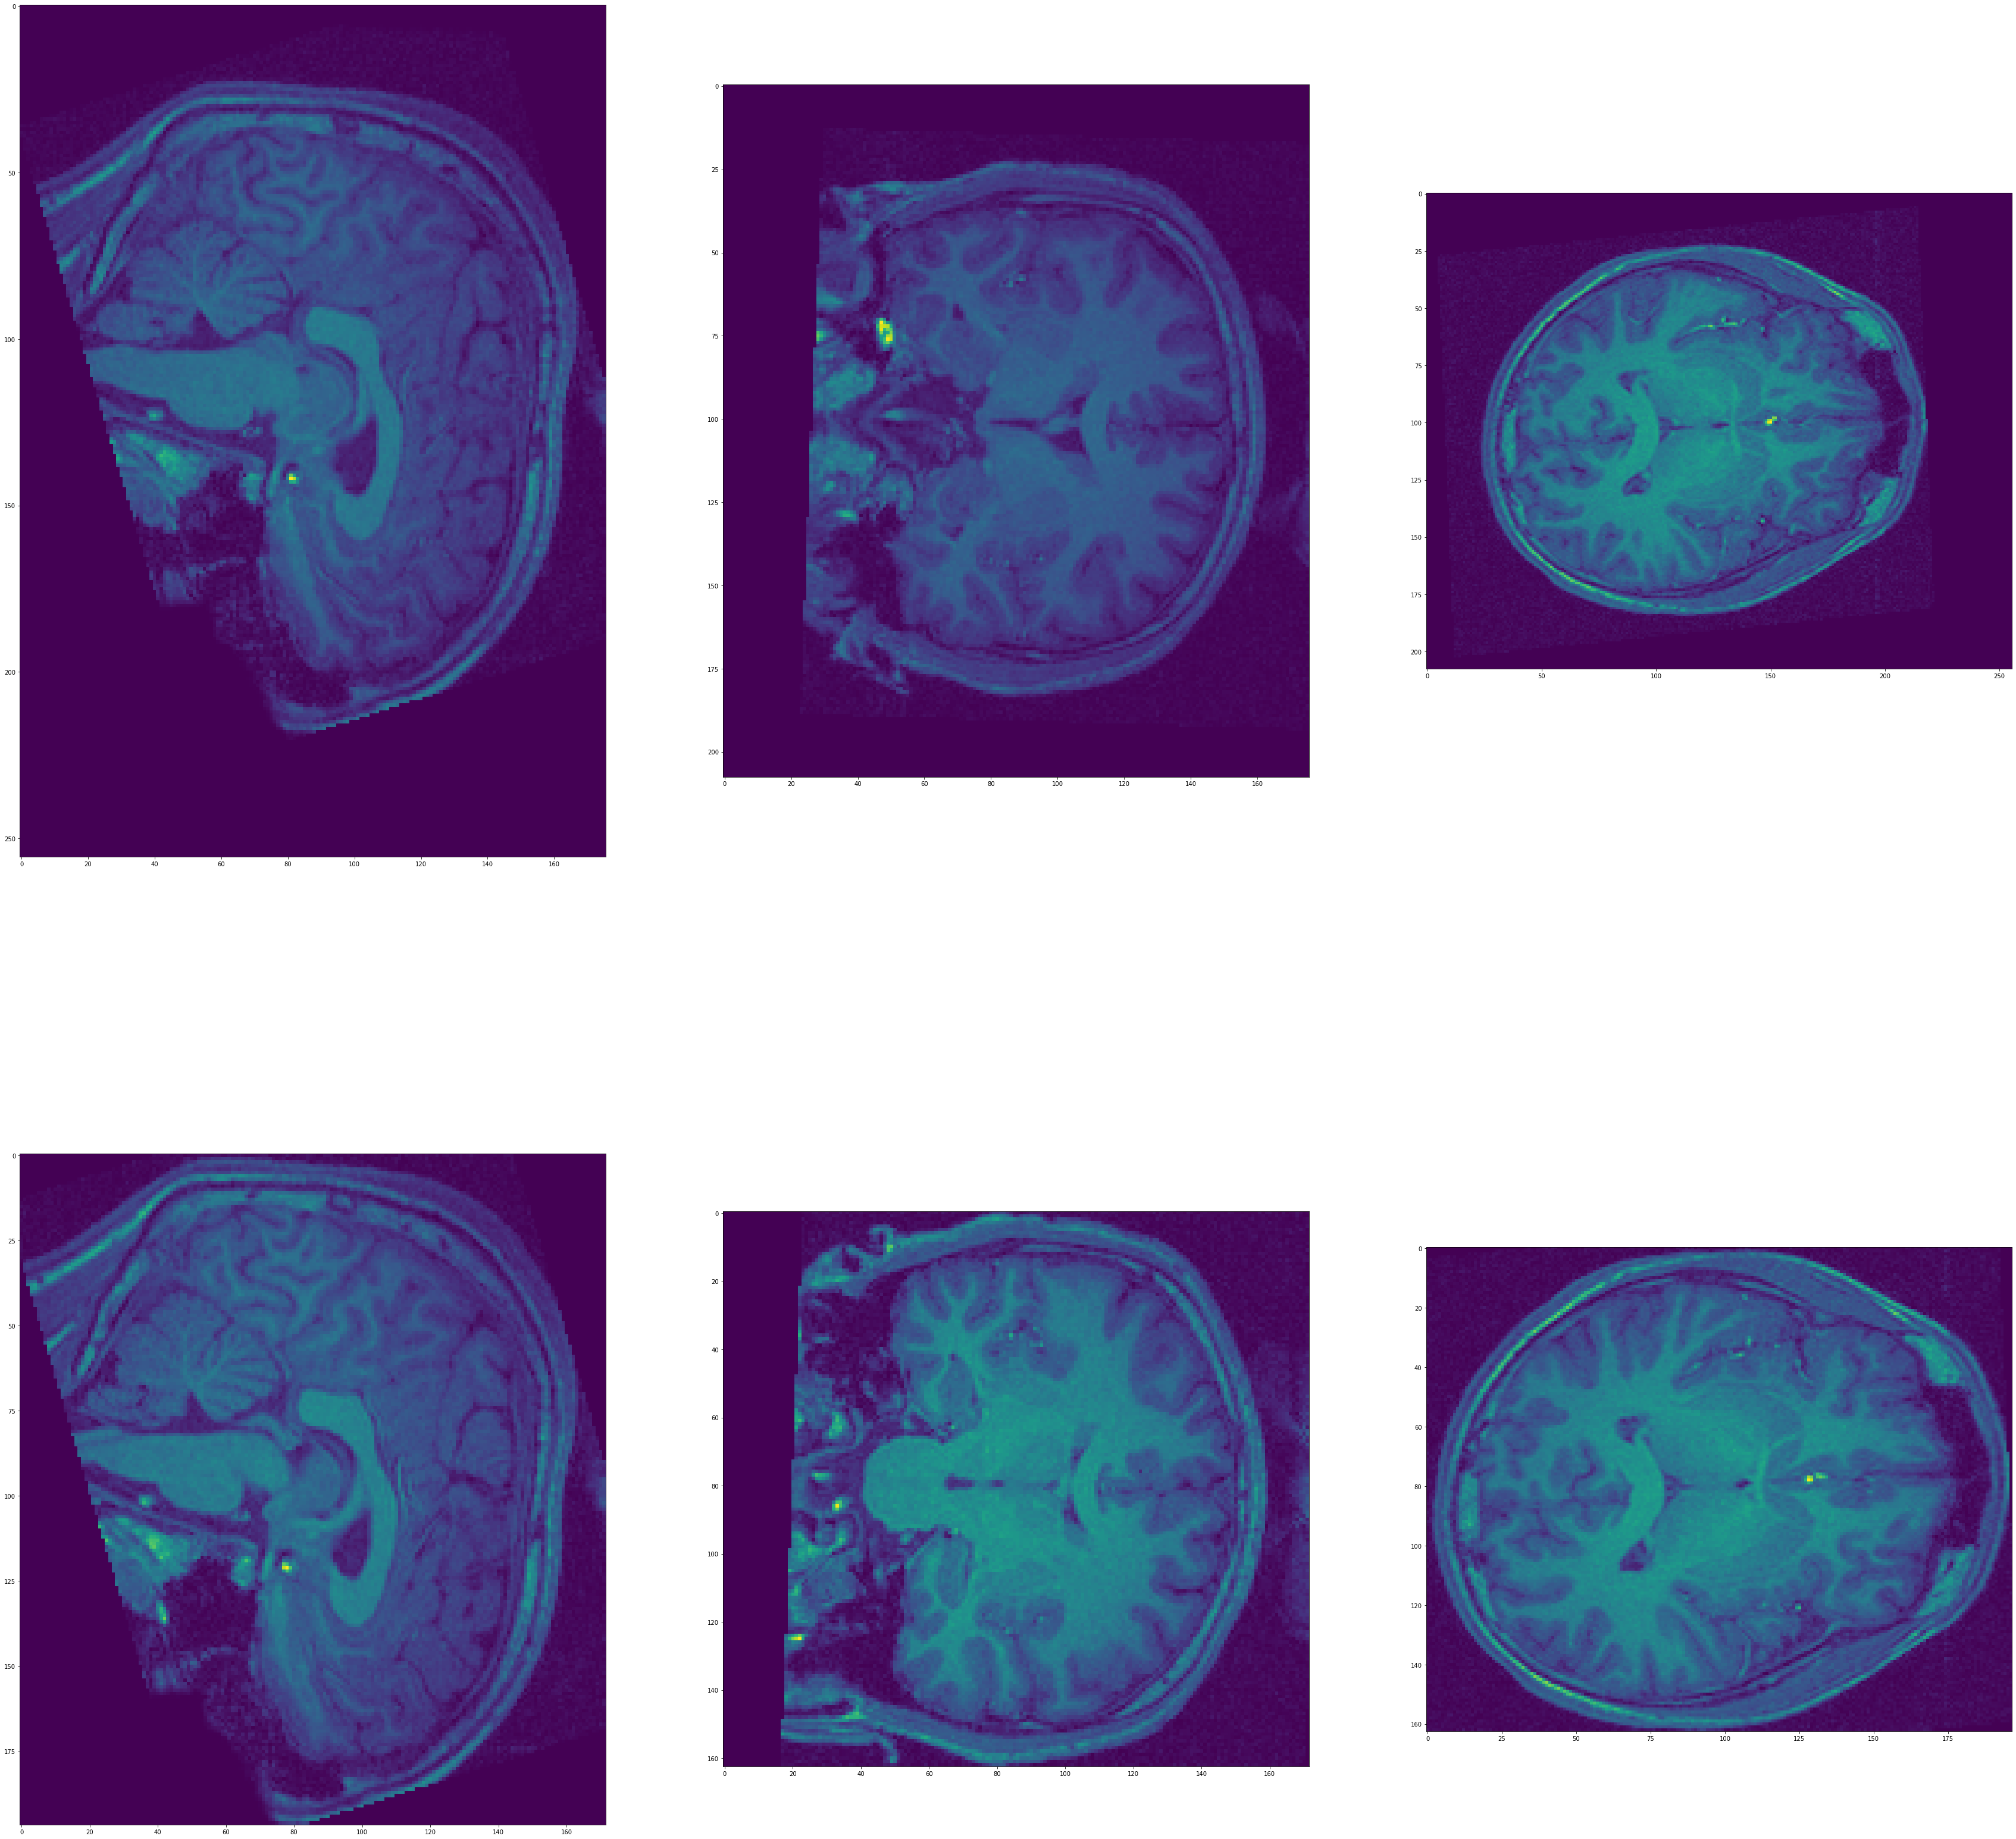

In [95]:
fig, axes = plt.subplots(2, 3, figsize=(60,60))
#fig.suptitle('Horizontally stacked subplots')

for i,ax in enumerate(axes):
    im = [sitk2np(image), sitk2np(imagecrop)][i]
    ax[0].imshow(np.take(im, im.shape[0]//2, axis=0))
    ax[1].imshow(np.take(im, im.shape[1]//2, axis=1))
    ax[2].imshow(np.take(im, im.shape[2]//2, axis=2))

In [22]:
from monai.transforms import LoadImaged, Spacingd

In [86]:
d = [{"im": im, "lbl":lbl} for im,lbl in all_filenames_nii]

min_pixdim = (0.2734000086784363, 1.7000000476837158, 0.2734000086784363)
#min_pixdim = (1, 1, 1)

d1 = LoadImaged(keys=["im","lbl"])(d[-1])
d2 = Spacingd(keys=["im","lbl"], pixdim=min_pixdim, mode=("bilinear", "nearest"))(d1)

In [83]:
d1

{'im': array([[[118.96508 ,  54.90696 ,  68.633705, ...,   4.57558 ,
            4.57558 ,   4.57558 ],
         [ 59.48254 ,  54.90696 ,  32.02906 , ...,   0.      ,
            4.57558 ,   0.      ],
         [118.96508 , 150.99414 , 118.96508 , ...,   4.57558 ,
            4.57558 ,   0.      ],
         ...,
         [ 59.48254 ,  86.93602 , 123.540665, ...,   0.      ,
            0.      ,   0.      ],
         [ 27.45348 ,  27.45348 ,  32.02906 , ...,   0.      ,
            0.      ,   0.      ],
         [ 50.331383,  64.05812 , 128.11624 , ...,   0.      ,
            0.      ,   0.      ]],
 
        [[ 73.20928 ,  27.45348 ,  54.90696 , ...,   0.      ,
            0.      ,   4.57558 ],
         [ 91.511604,  91.511604,  73.20928 , ...,   0.      ,
            4.57558 ,   0.      ],
         [ 64.05812 , 137.26741 , 109.81392 , ...,   4.57558 ,
            4.57558 ,   4.57558 ],
         ...,
         [ 91.511604,  96.08718 , 114.3895  , ...,   0.      ,
            0.    

In [84]:
d2

{'im': array([[[1.18965080e+02, 8.67378998e+01, 5.49180069e+01, ...,
          2.72737241e+00, 2.70096278e+00, 2.67455316e+00],
         [9.86224823e+01, 1.12482513e+02, 1.26244377e+02, ...,
          0.00000000e+00, 2.70174950e-01, 6.74752235e-01],
         [2.55086765e+01, 3.37369843e+01, 4.20115509e+01, ...,
          2.94408870e+00, 2.44282985e+00, 6.47584617e-01],
         ...,
         [5.03313828e+01, 5.72004509e+01, 6.41113205e+01, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [5.03313828e+01, 5.72004509e+01, 6.41113205e+01, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [5.03313828e+01, 5.72004509e+01, 6.41113205e+01, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
 
        [[7.32092819e+01, 5.05501785e+01, 2.82153091e+01, ...,
          3.73745871e+00, 3.98087192e+00, 3.02119064e+00],
         [6.96061020e+01, 9.59952545e+01, 1.22032173e+02, ...,
          3.85836911e+00, 2.81272602e+00, 1.35860038e+00],
 

In [85]:
d2["im"].shape, d2["lbl"].shape, d1["im"].shape, d1["lbl"].shape

((384, 11, 766), (384, 11, 766), (384, 20, 384), (384, 20, 384))

In [64]:
# in sitk

image = sitk.ReadImage(d[-1]["im"])
resample = sitk.ResampleImageFilter()
resample.SetInterpolator = sitk.sitkLinear
resample.SetOutputDirection = image.GetDirection()
resample.SetOutputOrigin = image.GetOrigin()
new_spacing = min_pixdim

orig_size = np.array(image.GetSize(), dtype=int)
orig_spacing = np.array(image.GetSpacing())

new_size = orig_size*(orig_spacing/new_spacing)
new_size = np.ceil(new_size).astype(int) #  Image dimensions are in integers

new_size = [int(s) for s in new_size]

resample.SetOutputSpacing(new_spacing)
resample.SetSize(new_size)

newimage = resample.Execute(image)


In [65]:
orig_size, orig_spacing

(array([384,  20, 384]), array([0.41666666, 2.        , 0.41666666]))

In [66]:
new_spacing

(0.2734000086784363, 1.7000000476837158, 0.2734000086784363)

In [67]:
orig_spacing/new_spacing, orig_spacing[0]/new_spacing[0]

(array([1.52401845, 1.17647056, 1.52401845]), 1.524018447353556)

In [68]:
newimage.GetSpacing(), image.GetSpacing(), image.GetSize(), newimage.GetSize()

((0.2734000086784363, 1.7000000476837158, 0.2734000086784363),
 (0.4166666567325592, 2.0, 0.4166666567325592),
 (384, 20, 384),
 (586, 24, 586))

In [71]:
im_np = sitk2np(image)
newim_np = sitk2np(newimage)

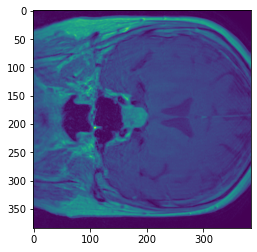

In [72]:
plt.imshow(im_np[:,10,:])

In [74]:
d1["im"].shape, d2["im"].shape

((384, 20, 384), (384, 37, 451))

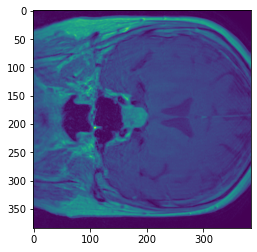

In [75]:
plt.imshow(d1["im"][:,10,:])

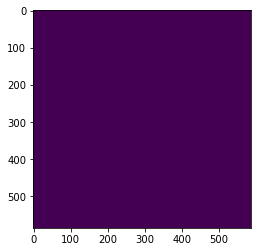

In [73]:
plt.imshow(newim_np[:,12,:])

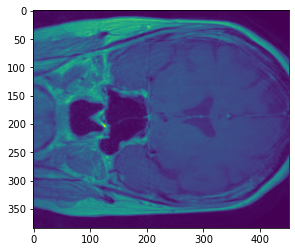

In [76]:
plt.imshow(d2["im"][:,18,:])

In [38]:
all_filenames_nii[0]

('/home/gologors/data/pitmri/las_nii/loni_im_ABIDE_50136_MRI_MP-RAGE_br_raw_20120830202014457_S165053_I329063.nii',
 '/home/gologors/data/pitmri/las_nii/loni_lbl_ABIDE_50136_MRI_MP-RAGE_br_raw_20120830202014457_S165053_I329063.nii')

In [45]:
#  img_data = [(o.GetSize(), o.GetSpacing()) for o in objs]

def get_im_data(fn):
    reader = sitk.ImageFileReader()

    reader.SetFileName(fn)
    reader.ReadImageInformation()

    return (reader.GetSize(), reader.GetSpacing())

im_data = [get_im_data(im_fn) for im_fn, seg_fn in all_filenames_nii if os.path.basename(im_fn).startswith("pit")]
print(len(im_data))

from statistics import median

def get_med(tuple_lst, i):
    l = [o[i] for o in tuple_lst]
    return median(l), min(l), max(l)

print("Median/Min/Max Size 0: ", get_med([o[1] for o in im_data], 0))
print("Median/Min/Max Size 1: ", get_med([o[1] for o in im_data], 1))
print("Median/Min/Max Size 2: ", get_med([o[1] for o in im_data], 2))

50
Median/Min/Max Size 0:  (0.41015625, 0.2734000086784363, 0.6875)
Median/Min/Max Size 1:  (3.0, 1.7000000476837158, 6.5)
Median/Min/Max Size 2:  (0.41015625, 0.2734000086784363, 0.6875)


In [43]:
count = 0
for sz,sp in im_data:
    if sp == (0.41015625, 3.0, 0.41015625):
        count += 1
print(count)

16


In [44]:
im_data

[((512, 16, 512), (0.41015625, 3.0, 0.41015625)),
 ((320, 14, 320), (0.40625, 2.75, 0.40625)),
 ((512, 18, 512), (0.41015625, 3.0, 0.41015625)),
 ((512, 14, 512), (0.37109375, 2.5, 0.37109375)),
 ((432, 24, 432), (0.4166666567325592, 2.200000047683716, 0.4166666567325592)),
 ((256, 24, 256), (0.625, 3.0, 0.625)),
 ((512, 17, 512), (0.41015625, 3.0, 0.41015625)),
 ((256, 11, 256), (0.5859375, 4.0, 0.5859375)),
 ((512, 16, 512), (0.41015625, 3.0, 0.41015625)),
 ((432, 18, 432), (0.4166666567325592, 2.200000047683716, 0.4166666567325592)),
 ((512, 18, 512), (0.41015625, 3.0, 0.41015625)),
 ((512, 16, 512), (0.41015625, 3.0, 0.41015625)),
 ((512, 16, 512), (0.3125, 3.0, 0.3125)),
 ((300, 15, 384), (0.5208333134651184, 2.0, 0.5208333134651184)),
 ((512, 16, 512), (0.41015625, 3.0, 0.41015625)),
 ((336, 14, 336), (0.5357142686843872, 3.299999952316284, 0.5357142686843872)),
 ((512, 17, 512), (0.3125, 3.990000009536743, 0.3125)),
 ((512, 18, 512), (0.3515999913215637, 3.299999952316284, 0.351

# Segm Obj -> SITK

In [7]:
# 1. Get affine matrix in SITK
# https://niftynet.readthedocs.io/en/v0.2.2/_modules/niftynet/io/simple_itk_as_nibabel.html
def make_affine(simpleITKImage, ras_adj):
    # get affine transform in LPS
    c = [simpleITKImage.TransformIndexToPhysicalPoint(p)
         for p in ((1, 0, 0),
                   (0, 1, 0),
                   (0, 0, 1),
                   (0, 0, 0))]
    c = np.array(c)
    affine = np.concatenate([
        np.concatenate([c[0:3] - c[3:], c[3:]], axis=0),
        [[0.], [0.], [0.], [1.]]
    ], axis=1)
    affine = np.transpose(affine)
    # convert to RAS to match nibabel
    if ras_adj:
        affine = np.matmul(np.diag([-1., -1., 1., 1.]), affine)
    return affine

In [8]:
# Read in fns
im         = sitk.ReadImage(im_fn, sitk.sitkFloat32)
lbl_mesh   = meshio.read(lbl_fn)

# Mesh -> boolean array (Delauney triangulation)
dims    = im.GetSize()
aff     = make_affine(im, ras_adj=False)
idx_pts = np.indices(dims[::-1], dtype=np.uint16).T.reshape(-1,3)[:,[2,1,0]]
physical_pts = (np.dot(aff[:3,:3], idx_pts.T) + aff[:3,3:4]).T 

In [9]:
lbl_arr = (Delaunay(lbl_mesh.points).find_simplex(physical_pts) >= 0).reshape(dims)

In [10]:
# Boolean arr -> SITK w/ same 
lbl = sitk.GetImageFromArray(np.swapaxes(lbl_arr.astype(np.uint8), 0, 2))
lbl.SetOrigin(im.GetOrigin())
lbl.SetSpacing(im.GetSpacing())   
lbl.SetDirection(im.GetDirection())

In [11]:
def print_sitk_info(image):    
    print("Size: ", image.GetSize())
    print("Origin: ", image.GetOrigin())
    print("Spacing: ", image.GetSpacing())
    print("Direction: ", image.GetDirection())
    print(f"Pixel type: {image.GetPixelIDValue()} = {image.GetPixelIDTypeAsString()}")

    
print_sitk_info(im); print("*"*100); print_sitk_info(lbl)

Size:  (336, 336, 7)
Origin:  (-99.03256225585938, -8.225259780883789, -97.74720764160156)
Spacing:  (0.5654761791229248, 0.5654761791229248, 3.299999952316284)
Direction:  (0.9948747222650136, -0.02164298249445778, 0.09877180340296449, -0.10049888205788328, -0.1039594651795248, 0.989490982540376, 0.011147273353955415, 0.9943460217189648, 0.10560173447348141)
Pixel type: 8 = 32-bit float
****************************************************************************************************
Size:  (336, 336, 7)
Origin:  (-99.03256225585938, -8.225259780883789, -97.74720764160156)
Spacing:  (0.5654761791229248, 0.5654761791229248, 3.299999952316284)
Direction:  (0.9948747222650136, -0.02164298249445778, 0.09877180340296449, -0.10049888205788328, -0.1039594651795248, 0.989490982540376, 0.011147273353955415, 0.9943460217189648, 0.10560173447348141)
Pixel type: 1 = 8-bit unsigned integer


In [12]:
# sitk obj and np array have different index conventions
# deep copy
def sitk2np(obj): return np.swapaxes(sitk.GetArrayFromImage(obj), 0, 2)
def np2sitk(arr): return sitk.GetImageFromArray(np.swapaxes(arr, 0, 2))

def torch2sitk(t): return sitk.GetImageFromArray(torch.transpose(t, 0, 2))
def sitk2torch(o): return torch.transpose(torch.tensor(sitk.GetArrayFromImage(o)), 0, 2)


def viz_anno(mr, seg):
    
    mr, seg = np.array(mr), np.array(seg)
    gt_bbox = mask2bbox(seg)
    
    bbox = gt_bbox
    
    # print bbox
    #print("Pred: "); print_bbox(*pred_bbox)
    print("GT: "); print_bbox(*gt_bbox)
          
    # viz
    viz_axis(np_arr = mr, \
            bin_mask_arr   = seg,     color1 = "yellow",  alpha1=0.3, \
            #bin_mask_arr2  = pred_mk, color2 = "magenta", alpha2=0.3, \
            slices=lrange(*bbox[4:6]), fixed_axis=2, \
            axis_fn = np.rot90, \
            title   = "Axis 2", \

#             np_arr_b = mr, \
#             bin_mask_arr_b   = seg,     color1_b = "yellow",  alpha1_b=0.3, \
#             bin_mask_arr2_b  = pred_mk, color2_b = "magenta", alpha2_b=0.3, \
#             slices_b = lrange(*bbox[2:4]), fixed_axis_b=1, \
#             title_b  = "Axis 1", \

#             np_arr_c = mr, \
#             bin_mask_arr_c   = seg,     color1_c = "yellow",  alpha1_c=0.3, \
#             bin_mask_arr2_c  = pred_mk, color2_c = "magenta", alpha2_c=0.3, \
#             slices_c = lrange(*bbox[4:6]), fixed_axis_c=2, \
#             title_c = "Axis 2", \
  
        ncols = 5, hspace=0.3, fig_mult=2) 

GT: 
Bbox coords: (131, 119, 0) to (204, 186, 7). Size: 73, 67, 7.
Bounding box coord: from location (119, 0) of slice 131 to location (186, 7) of slice 204.
hi
2 5
True opt


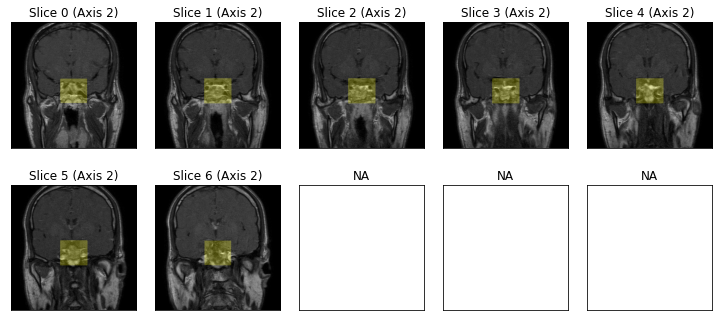

In [13]:
im_arr  = sitk2np(im)
lbl_arr = sitk2np(lbl)

viz_anno(im_arr, lbl_arr)

# Save Mesh Labels as Nii

In [14]:
def get_stem_name(fn):
    basename = os.path.basename(fn)
    return basename[:basename.index(".nii")]

for a in im_fns:
    print(get_stem_name(a))

2.25.184249200549587298191910596089011880848_t1_se_r_cor_20160926211853_7
1.3.46.670589.11.37169.5.0.7164.2016102004110442509_COR_T1_CLEAR_20161020033557_701
1.3.46.670589.11.37169.5.0.7164.2016102005322626072_COR_T1_CLEAR_20161020045705_701
1.3.46.670589.11.70769.5.0.6828.2016112311204114626_+COR_T1_THIN_SENSE_20161123104913_901
2.25.128099500521260683799022260026606955306_+Cor_T1_THIN_20161018100638_13
1.3.46.670589.11.37169.5.0.7064.2016102904242870274_COR_T1_CLEAR_20161029040301_701
1.3.46.670589.11.37169.5.0.8820.2016110101521229038_COR_T1_CLEAR_20161101012852_701
2.25.261945188120165157234217181512902374008_COR_T1_SE_20160919105232_3
1.3.46.670589.11.37169.5.0.3436.2016110300230654926_COR_T1_CLEAR_20161103000404_701
1.3.46.670589.11.42053.5.0.4772.2016110301201227714_COR_T1_CLEAR_20161103010128_801
1.3.46.670589.11.42001.5.0.5556.2016110816312576639_COR_T1_CLEAR_20161108160627_801
2.25.146054966958629375559310130923372327960_COR_T1_THIN_20160929162220_1401
1.3.46.670589.11.37169.

In [ ]:
i = 0

for im_fn, lbl_fn in all_filenames:
    # Read in fns
    im         = sitk.ReadImage(im_fn, sitk.sitkFloat32)
    lbl_mesh   = meshio.read(lbl_fn)

    # Mesh -> boolean array (Delauney triangulation)
    dims    = im.GetSize()
    aff     = make_affine(im, ras_adj=False)
    idx_pts = np.indices(dims[::-1], dtype=np.uint16).T.reshape(-1,3)[:,[2,1,0]]
    physical_pts = (np.dot(aff[:3,:3], idx_pts.T) + aff[:3,3:4]).T 
    
    lbl_arr = (Delaunay(lbl_mesh.points).find_simplex(physical_pts) >= 0).reshape(dims)

    # Boolean arr -> SITK w/ same 
    lbl = sitk.GetImageFromArray(np.swapaxes(lbl_arr.astype(np.uint8), 0, 2))
    lbl.SetOrigin(im.GetOrigin())
    lbl.SetSpacing(im.GetSpacing())   
    lbl.SetDirection(im.GetDirection())
    
    # Re-orient to LAS
    im = sitk.DICOMOrient(im, "LAS")
    lbl = sitk.DICOMOrient(lbl, "LAS")
    
    # Save as .nii
    basename = get_stem_name(im_fn)
    
    writer = sitk.ImageFileWriter()
    writer.SetFileName(root + 'pitmri/las_nii/im_' + basename + '.nii')
    writer.Execute(im)
    
    writer.SetFileName(root + 'pitmri/las_nii/lbl_' + basename + '.nii')
    writer.Execute(lbl)
                             
    # Save as pytorch tensor
#     lbl_pt = sitk2torch(lbl)
#     im_pt  = sitk2torch(im)
    
#     basename = get_stem_name(im_fn)
#     torch.save(im_pt, root + 'pitmri/loni_dset/im_' + basename + '.pt')
#     torch.save(lbl_pt, root + 'pitmri/loni_dset/lbl_' + basename + '.pt')
    
    # Counter
    print(f"Done {i}")
    i += 1

Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 10
Done 11
Done 12
Done 13
Done 14
Done 15
Done 16
Done 17
Done 18
Done 19
Done 20
Done 21
Done 22
Done 23
Done 24
Done 25
Done 26
Done 27
Done 28
Done 29
Done 30
Done 31
Done 32
Done 33
Done 34
Done 35
Done 36
Done 37
Done 38
Done 39
Done 40
Done 41
Done 42
Done 43
Done 44
Done 45
Done 46
Done 47
Done 48
Done 49
Done 50
Done 51
Done 52
Done 53
Done 54
Done 55
Done 56
Done 57
Done 58
Done 59
Done 60
Done 61
Done 62
Done 63
Done 64
Done 65
Done 66
Done 67
Done 68
Done 69
Done 70
Done 71
Done 72
Done 73
Done 74
Done 75
Done 76
Done 77
Done 78
Done 79
Done 80
Done 81
Done 82
Done 83
Done 84
Done 85
Done 86
Done 87
Done 88
Done 89
Done 90
Done 91
Done 92
Done 93
Done 94
Done 95
Done 96
Done 97
Done 98
Done 99
Done 100
Done 101
Done 102
Done 103
Done 104


In [17]:
# Get Labels
with open(root + 'pitmri/' + 'all_filenames.pkl', 'rb') as f: 
    all_filenames = pickle.load(f)

In [18]:
i = 0

for im_fn, lbl_fn in all_filenames:
    # Read in fns
    im         = sitk.ReadImage(im_fn, sitk.sitkFloat32)
    lbl_mesh   = meshio.read(lbl_fn)

    # Mesh -> boolean array (Delauney triangulation)
    dims    = im.GetSize()
    aff     = make_affine(im, ras_adj=False)
    idx_pts = np.indices(dims[::-1], dtype=np.uint16).T.reshape(-1,3)[:,[2,1,0]]
    physical_pts = (np.dot(aff[:3,:3], idx_pts.T) + aff[:3,3:4]).T 
    
    lbl_arr = (Delaunay(lbl_mesh.points).find_simplex(physical_pts) >= 0).reshape(dims)

    # Boolean arr -> SITK w/ same 
    lbl = sitk.GetImageFromArray(np.swapaxes(lbl_arr.astype(np.uint8), 0, 2))
    lbl.SetOrigin(im.GetOrigin())
    lbl.SetSpacing(im.GetSpacing())   
    lbl.SetDirection(im.GetDirection())
    
    # Re-orient to LAS
    im = sitk.DICOMOrient(im, "LAS")
    lbl = sitk.DICOMOrient(lbl, "LAS")
    
    # Save as pytorch tensor
    lbl_pt = sitk2torch(lbl)
    im_pt  = sitk2torch(im)
    
    basename = get_stem_name(im_fn)
    torch.save(im_pt, root + 'pitmri/dset/im_' + basename + '.pt')
    torch.save(lbl_pt, root + 'pitmri/dset/lbl_' + basename + '.pt')
    
    # Counter
    print(f"Done {i}")
    i += 1

Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 10
Done 11
Done 12
Done 13
Done 14
Done 15
Done 16
Done 17
Done 18
Done 19
Done 20
Done 21
Done 22
Done 23
Done 24
Done 25
Done 26
Done 27
Done 28
Done 29
Done 30
Done 31
Done 32
Done 33
Done 34
Done 35
Done 36
Done 37
Done 38
Done 39
Done 40
Done 41
Done 42
Done 43
Done 44
Done 45
Done 46
Done 47
Done 48
Done 49


In [19]:
# Save pt fnamses

all_filenames_pt = []
for im_fn, lbl_fn in all_filenames:
    basename = get_stem_name(im_fn)
    im_fn_pt  = root + 'pitmri/dset/im_' + basename + '.pt'
    lbl_fn_pt = root + 'pitmri/dset/lbl_' + basename + '.pt'
    
    all_filenames_pt.append((im_fn_pt, lbl_fn_pt))
    
print("N = ", len(all_filenames_pt))


# Save
with open(root + 'pitmri/' + 'all_filenames_pt.pkl', 'wb') as f:
    pickle.dump(all_filenames_pt, f)

N =  50


In [ ]:
# Save pt fnamses

all_filenames_pt = []
for im_fn, lbl_fn in all_filenames:
    basename = get_stem_name(im_fn)
    im_fn_pt  = root + 'pitmri/dset/im_' + basename + '.pt'
    lbl_fn_pt = root + 'pitmri/dset/lbl_' + basename + '.pt'
    
    all_filenames_pt.append((im_fn_pt, lbl_fn_pt))
    
print("N = ", len(all_filenames_pt))


# Save
with open(root + 'pitmri/' + 'all_filenames_pt.pkl', 'wb') as f:
    pickle.dump(all_filenames_pt, f)

In [20]:
for im_fn, lbl_fn in all_filenames_pt:
    lbl_pt = torch.load(lbl_fn)
    print(lbl_pt.shape)

torch.Size([512, 16, 512])
torch.Size([320, 14, 320])
torch.Size([512, 18, 512])
torch.Size([512, 14, 512])
torch.Size([432, 24, 432])
torch.Size([256, 24, 256])
torch.Size([512, 17, 512])
torch.Size([256, 11, 256])
torch.Size([512, 16, 512])
torch.Size([432, 18, 432])
torch.Size([512, 18, 512])
torch.Size([512, 16, 512])
torch.Size([512, 16, 512])
torch.Size([300, 15, 384])
torch.Size([512, 16, 512])
torch.Size([336, 14, 336])
torch.Size([512, 17, 512])
torch.Size([512, 18, 512])
torch.Size([512, 16, 512])
torch.Size([576, 17, 640])
torch.Size([256, 11, 256])
torch.Size([512, 20, 512])
torch.Size([512, 18, 512])
torch.Size([512, 16, 512])
torch.Size([512, 25, 512])
torch.Size([512, 18, 512])
torch.Size([448, 14, 448])
torch.Size([336, 14, 336])
torch.Size([512, 16, 512])
torch.Size([432, 18, 432])
torch.Size([384, 13, 384])
torch.Size([512, 12, 512])
torch.Size([432, 22, 432])
torch.Size([400, 42, 400])
torch.Size([288, 20, 288])
torch.Size([512, 15, 512])
torch.Size([256, 17, 256])
t

In [21]:
# Get Labels
with open(root + 'pitmri/' + 'all_loni_filenames.pkl', 'rb') as f: 
    all_loni_filenames = pickle.load(f)
    
# Save pt fnamses

all_loni_filenames_pt = []
for im_fn, lbl_fn in all_loni_filenames:
    basename = get_stem_name(im_fn)
    im_fn_pt  = root + 'pitmri/loni_dset/im_' + basename + '.pt'
    lbl_fn_pt = root + 'pitmri/loni_dset/lbl_' + basename + '.pt'
    
    all_loni_filenames_pt.append((im_fn_pt, lbl_fn_pt))
    
print("N = ", len(all_loni_filenames_pt))


# Save
with open(root + 'pitmri/' + 'all_loni_filenames_pt.pkl', 'wb') as f:
    pickle.dump(all_loni_filenames_pt, f)

N =  337


# Ref

In [ ]:
# Preprocess Helper fns
#
#  1. make_affine/segm2mask
#  2. get_isotropic
#  3. get_data_dict
#  4. folder2objs
#  5. mask2bbox / print bbox
#  6. crop thershold
#  7. resample2reference
#  8. get largest connected copmonent

# segmentation
from scipy.spatial   import Delaunay
    
# given paths, return isotropic SITK obj of nii and segm obj
def paths2objs(mr_path, segm_path, ras_adj = False):
    mr         = sitk.ReadImage(mr_path, sitk.sitkFloat32)
    segm       = meshio.read(segm_path)
    mask_arr   = seg2mask(mr, segm, ras_adj)
    
    return mr, mask2sitk(mask_arr, mr)


# Convert segmentation object to numpy binary mask
# 1. Get affine matrix in SITK (aff tfm: idx coord => physical space coord)
# 2. Convert image idxs to physical coords
# 3. Check whether physical coords are in the Delauney triangulation of segmented mesh points

# 1. Get affine matrix in SITK
# https://niftynet.readthedocs.io/en/v0.2.2/_modules/niftynet/io/simple_itk_as_nibabel.html
def make_affine(simpleITKImage, ras_adj):
    # get affine transform in LPS
    c = [simpleITKImage.TransformIndexToPhysicalPoint(p)
         for p in ((1, 0, 0),
                   (0, 1, 0),
                   (0, 0, 1),
                   (0, 0, 0))]
    c = np.array(c)
    affine = np.concatenate([
        np.concatenate([c[0:3] - c[3:], c[3:]], axis=0),
        [[0.], [0.], [0.], [1.]]
    ], axis=1)
    affine = np.transpose(affine)
    # convert to RAS to match nibabel
    if ras_adj:
        affine = np.matmul(np.diag([-1., -1., 1., 1.]), affine)
    return affine

# Seg2mask
def seg2mask(image_obj, segm_obj, ras_adj):
    dims = image_obj.GetSize()
    aff     = make_affine(image_obj, ras_adj)
    idx_pts = np.indices(dims[::-1], dtype=np.uint16).T.reshape(-1,3)[:,[2,1,0]]
    physical_pts = (np.dot(aff[:3,:3], idx_pts.T) + aff[:3,3:4]).T 
    return (Delaunay(segm_obj.points).find_simplex(physical_pts) >= 0).reshape(dims)

# https://stackoverflow.com/questions/31400769/bounding-box-of-numpy-array
# https://stackoverflow.com/questions/39206986/numpy-get-rectangle-area-just-the-size-of-mask/48346079
def mask2bbox(mask):

    mask = mask.astype(bool)
    
    i = np.any(mask, axis=(1, 2))
    j = np.any(mask, axis=(0, 2))
    k = np.any(mask, axis=(0, 1))

    imin, imax = np.where(i)[0][[0, -1]]
    jmin, jmax = np.where(j)[0][[0, -1]]
    kmin, kmax = np.where(k)[0][[0, -1]]

    # inclusive idxs
    return imin, imax+1, jmin, jmax+1, kmin, kmax+1

def get_bbox_size(imin, imax, jmin, jmax, kmin, kmax):
    return imax - imin, jmax-jmin, kmax-kmin

def print_bbox_size(imin, imax, jmin, jmax, kmin, kmax):
    print(f"{imax - imin}, {jmax-jmin}, {kmax-kmin}")
    
def print_bbox(imin, imax, jmin, jmax, kmin, kmax):
    print(f"Bbox coords: ({imin}, {jmin}, {kmin}) to ({imax}, {jmax}, {kmax}). Size: {imax - imin}, {jmax-jmin}, {kmax-kmin}.")
    print(f"Bounding box coord: from location ({jmin}, {kmin}) of slice {imin} to location ({jmax}, {kmax}) of slice {imax}.")
    #print(f"Slices: {imin}, {imax} ({imax-imin}), Rows: {jmin}, {jmax} ({jmax-jmin}), Cols: {kmin}, {kmax} ({kmax-kmin}).")
        

def get_bbox_vals(i,j,k):
    imin, imax = torch.where(i)[0][[0, -1]]
    jmin, jmax = torch.where(j)[0][[0, -1]]
    kmin, kmax = torch.where(k)[0][[0, -1]]
    
    # inclusive indices
    return torch.tensor([imin, imax+1, jmin, jmax+1, kmin, kmax+1])

def torch_mask2bbox(mask):
    k = torch.any(torch.any(mask, dim=0), dim=0) # 0 -> 1,2 -> 1 -> 2 left
    j = torch.any(torch.any(mask, dim=0), dim=1) # 0 -> 1,2 -> 2 -> 1 left
    i = torch.any(torch.any(mask, dim=1), dim=1) # 1 -> 0,2 -> 0 -> 0 left
    return get_bbox_vals(i,j,k)
        
def batch_get_bbox(yb, preds=False):
    # BCDHW => BDHW, assumed C
    if preds:
        masks = torch.argmax(yb, dim=1).byte()
    else:
        masks =yb.squeeze(1).byte()
    
    # batchwise BDHW
    # BDHW -> BHW -> BW
    # BDHW -> BHW -> BH
    # BDHW -> BDW -> BD 
    bk = torch.any(torch.any(masks, dim=1), dim=1) # 0 -> 1,2 -> 1 -> 2 left
    bj = torch.any(torch.any(masks, dim=1), dim=2) # 0 -> 1,2 -> 2 -> 1 left
    bi = torch.any(torch.any(masks, dim=2), dim=2) # 1 -> 0,2 -> 0 -> 0 left

    # for b in batch
    return torch.stack([get_bbox_vals(i,j,k) for i,j,k in zip(bi,bj,bk)], dim=0)



In [ ]:

def print_hardware_stats():
    # print GPU/CPU counts
    gpu_count = torch.cuda.device_count()
    cpu_count = os.cpu_count()
    print("#GPU = {0:d}, #CPU = {1:d}".format(gpu_count, cpu_count))

    # print GPU stats
    GPUs = GPU.getGPUs()
    for gpu in GPUs:
        print("GPU {0:20s} RAM Free: {1:.0f}MB | Used: {2:.0f}MB | Util {3:3.0f}% | Total {4:.0f}MB".format(gpu.name, gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

# sitk obj and np array have different index conventions
# deep copy
def sitk2np(obj): return np.swapaxes(sitk.GetArrayFromImage(obj), 0, 2)
def np2sitk(arr): return sitk.GetImageFromArray(np.swapaxes(arr, 0, 2))

def torch2sitk(t): return sitk.GetImageFromArray(torch.transpose(t, 0, 2))
def sitk2torch(o): return torch.transpose(torch.tensor(sitk.GetArrayFromImage(o)), 0, 2)

# numpy mask arr into sitk obj
def mask2sitk(mask_arr, sitk_image):
  # convert bool mask to int mask
  # swap axes for sitk
  obj = sitk.GetImageFromArray(np.swapaxes(mask_arr.astype(np.uint8), 0, 2))
  obj.SetOrigin(sitk_image.GetOrigin())
  obj.SetSpacing(sitk_image.GetSpacing())   
  obj.SetDirection(sitk_image.GetDirection())
  return obj

def print_sitk_info(image):    
    print("Size: ", image.GetSize())
    print("Origin: ", image.GetOrigin())
    print("Spacing: ", image.GetSpacing())
    print("Direction: ", image.GetDirection())
    print(f"Pixel type: {image.GetPixelIDValue()} = {image.GetPixelIDTypeAsString()}")


In [ ]:
# plot

from helpers.viz import viz_axis, viz_compare_inputs, viz_compare_outputs
from helpers.viz import *